# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from tqdm.notebook import trange, tqdm

In [ ]:
def show_img(im, ax=None, figsize=(8,8), title=None):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3)
    ax.imshow(im[:,:,::-1]);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if title: ax.set_title(title)
    return ax

In [ ]:
def show_imgs(ims, rows=1, figsize=(16,8), title=[None]):
    title = title*len(ims) if len(title) == 1 else title
    _,ax = plt.subplots(rows, len(ims)//rows, figsize=figsize)
    for im,ax_,tit in zip(ims,ax.flatten(),title):
        show_img(im,ax_,title=tit)
    return ax

# Datasets

## MNIST

You have already seen the MNIST dataset in one of the previous notebooks. [MNIST](https://en.wikipedia.org/wiki/MNIST_database) is a dataset of 70,000 hand-written digits, stored as greyscale `28x28` pixel images. It has played a very important role in the field of computer vision, but is now considered a 'toy' dataset, i.e. a dataset that can be used for making sure your algoritm works as expected but not necessarily to build something useful. Existing algorithms achieve over 99.8% classification accuracy on MNIST and are used by banks to automatically recognise the amounts on checks, and by the postal service to automatically recognize post codes.

![](https://camo.githubusercontent.com/d440ac2eee1cb3ea33340a2c5f6f15a0878e9275/687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067)

MNIST dataset can be downloaded from a number of different sources. Many machine learning frameworks include MNIST in their dataset library.

In [ ]:
%%time
# takes up to 30s to run for the first time
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')  # parser='auto' because it was giving a warning

CPU times: user 6.73 s, sys: 1.25 s, total: 7.98 s
Wall time: 16.1 s


In [ ]:
X.shape, y.shape

((70000, 784), (70000,))

In [ ]:
Xr = X.reshape(-1,28,28)/255  # what does "-1" mean here?
Xr.shape

(70000, 28, 28)

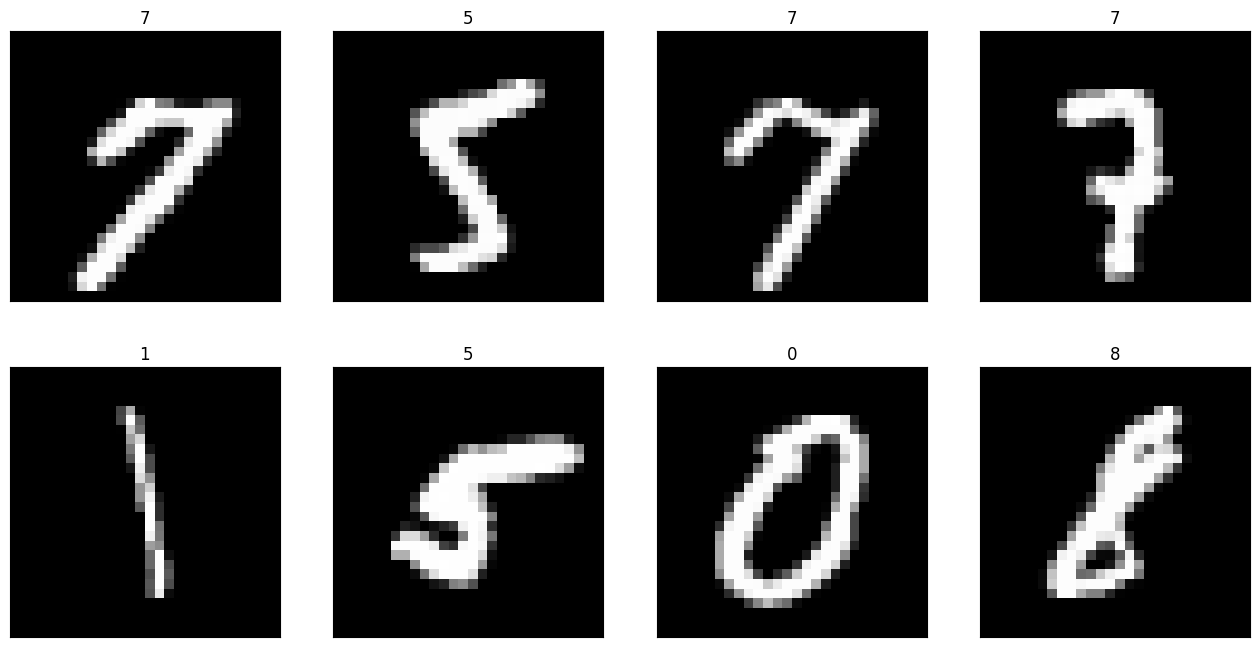

In [ ]:
ix = np.random.randint(0, len(y), (8,))
show_imgs(Xr[ix], rows=2, title=y[ix]);

## Fashion MNIST

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of 70,000 greyscale images of clothing items coming from 10 different classes. It is a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

In [ ]:
# i2c (integer to class) and c2i (class to integer)
i2c = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
c2i = {k:v for v,k in enumerate(i2c)}  # what does 'enumerate' do?
c2i['Coat']

4

In [ ]:
%%time
# takes up to 30s to run for the first time
X, y = fetch_openml('Fashion-MNIST', return_X_y=True, as_frame=False, parser='auto')  # parser='auto' because it was giving a warning

CPU times: user 8.73 s, sys: 935 ms, total: 9.66 s
Wall time: 27.3 s


In [ ]:
X.shape, y.shape

((70000, 784), (70000,))

In [ ]:
y[:10]

array(['9', '0', '0', '3', '0', '2', '7', '2', '5', '5'], dtype=object)

In [ ]:
y = y.astype(int)
y[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])

In [ ]:
i2c[y[:10]]

array(['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top',
       'Pullover shirt', 'Sneaker', 'Pullover shirt', 'Sandal', 'Sandal'],
      dtype='<U14')

In [ ]:
Xr = X.reshape(-1,28,28)/255
Xr.shape

(70000, 28, 28)

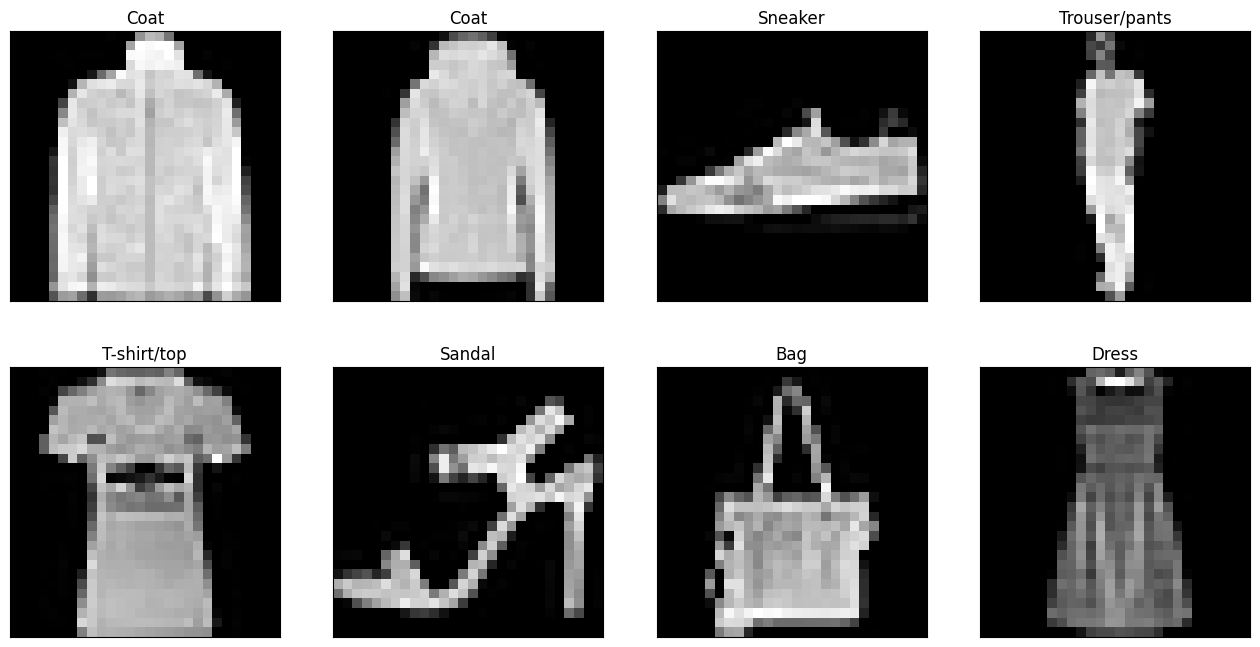

In [ ]:
ix = np.random.randint(0, len(y), (8,))
show_imgs(Xr[ix], rows=2, title=i2c[y[ix]]);

## Train/validation split

In [ ]:
sz_val = 10000

In [ ]:
np.random.seed(123)
ix = np.random.permutation(Xr.shape[0])
ix[:10]

array([21971, 16953, 48447, 42344,  4376, 65743, 64717,  2820, 57997,
       25377])

In [ ]:
Xval, yval = Xr[ix[:sz_val]], y[ix[:sz_val]]
Xtr,  ytr  = Xr[ix[sz_val:]], y[ix[sz_val:]]

In [ ]:
Xtr.shape, Xval.shape

((60000, 28, 28), (10000, 28, 28))

## Standardisation / normalisation

Many machine learning algorithms behave better when the data is *standardised*, that is when the mean is $0$ and the standard deviation is $1$. We will subtract off the mean and divide by the standard deviation calculated for our **training set** in order to standardise the data:

In [ ]:
μ,σ = Xtr.mean(), Xtr.std()
μ,σ

(np.float64(0.28607249674869867), np.float64(0.35299758447080976))

In [ ]:
Xtr_norm  = (Xtr  - μ) / σ
Xval_norm = (Xval - μ) / σ

In [ ]:
Xtr_norm.mean(), Xtr_norm.std(), Xval_norm.mean(), Xval_norm.std()

(np.float64(2.259858211370748e-15),
 np.float64(0.9999999999999996),
 np.float64(0.0016583269402254716),
 np.float64(0.998887041198154))

## PyTorch Dataset and Dataloader

In [ ]:
import torch as tc
from torch.utils.data import Dataset, DataLoader

In [ ]:
Dataset??

In [ ]:
class FashionMNIST(Dataset):
    def __init__(self, x, y): self.x, self.y = tc.tensor(x).float(), tc.tensor(y).long()
    def __len__(self): return len(self.x)
    def __getitem__(self, ix): return self.x[ix], self.y[ix]

In [ ]:
tr_ds  = FashionMNIST(Xtr, ytr)
val_ds = FashionMNIST(Xval, yval)

In [ ]:
len(tr_ds)  # this calls the __len__() function of our dataset object

60000

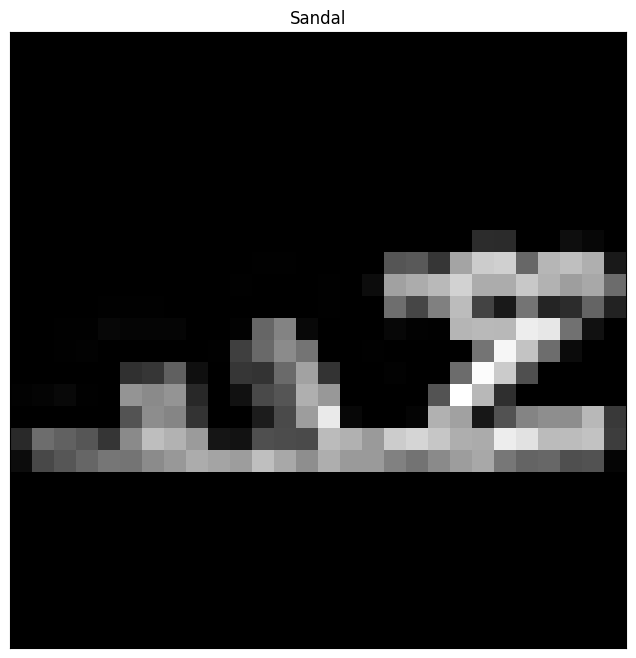

In [ ]:
show_img(tr_ds[1][0], title=i2c[tr_ds[1][1]]);  # [i] calls the __getitem__(i) function of our dataset object

The batch size denotes the number of examples/images we will use for gradient calculation. The choices are:
- `bs=60000` (i.e. the whole training set) - Gradient Descent (GD), used for smaller datasets when neural networks were popular in the 1980s
- `bs=1` - (i.e. one training example) - Stochastic Gradient Descent (SGD), not really used because the gradients are noisy and it's inefficient
- `1 < bs < 4096*` - mini-batch SGD (this is what people mean when they say SGD these days)

*there's really no upper bound here apart from the trainig set size, but 59800 wouldn't make much sense; you'd normally go for as big a batch, as can fit in your GPU memory

Nvidia GPUs like tensor sizes to be `multiples of 8` for maximum performance.

In [ ]:
bs = 8

In [ ]:
tr_dl  = DataLoader(tr_ds,  batch_size=bs,   shuffle=True,  num_workers=2) # set num_workers to your CPU core count
val_dl = DataLoader(val_ds, batch_size=2*bs, shuffle=False, num_workers=2)

In [ ]:
xb, yb = next(iter(tr_dl))
xb.shape, yb

(torch.Size([8, 28, 28]), tensor([8, 5, 0, 3, 6, 1, 7, 0]))

In [ ]:
xb, yb = next(iter(val_dl))
xb.shape, yb

(torch.Size([16, 28, 28]),
 tensor([0, 1, 1, 9, 8, 9, 5, 3, 4, 3, 2, 8, 5, 8, 4, 4]))

In [ ]:
i2c[yb]

array(['T-shirt/top', 'Trouser/pants', 'Trouser/pants', 'Ankle boot',
       'Bag', 'Ankle boot', 'Sandal', 'Dress', 'Coat', 'Dress',
       'Pullover shirt', 'Bag', 'Sandal', 'Bag', 'Coat', 'Coat'],
      dtype='<U14')

# Logistic Regression and Neural Networks

Logistic Regression is an example of a simplest, shallow neural network.

A **neural network** is an [infinitely flexible](https://en.wikipedia.org/wiki/Universal_approximation_theorem) function consisting of layers. A layer is a linear function such as convolution or matrix multiplication followed by a non-linearity (also known as *activation*). Non-linearity is essential here as composition of linear functions doesn't make sense!

In [ ]:
import torch as tc
import torch.nn as nn        # layers
import torch.optim as optim  # optimisers

## The model

In [ ]:
net = nn.Sequential(            # PyTorch's way of composing functions
    nn.Linear(28*28, 10),       # 1st function/layer
    nn.LogSoftmax(dim=1)        # 2nd function/layer
).cuda()                        # move the network to default CUDA device (GPU), see torch.cuda.set_device(device)

Each input is a vector of size `28*28` pixels and our output is of size `10` (since there are 10 classes).

The output of the linear layer generates predictions, which are then converted to comparative probabilities via the [Softmax](https://livebournemouthac-my.sharepoint.com/:x:/g/personal/mbudka_bournemouth_ac_uk/Ed1lRr-F56pMtBlLr4tDCTIBDQY_4Abt1IwSOBr73nxvpA?e=cEcp92) function.

Most of the time, the last layer will have the same number of outputs as the number of classes (10 in our case). The exception is two-class problem, where you don't need 2 outputs.

## The loss

In [ ]:
loss = nn.NLLLoss()

From documentation of `NLLoss`:

Obtaining log-probabilities in a neural network is easily achieved by adding a  `LogSoftmax`  layer in the last layer of your network.
You may use `CrossEntropyLoss` instead, if you prefer not to add an extra layer.

The `target` that this loss expects should be a class index in the range `[0, C-1]` where `C = number of classes`.

Let's see what `LogSoftmax` and `NLLLoss` do:

In [ ]:
# dummy input
inp = tc.tensor([[1,2,3]], requires_grad=False, dtype=tc.float)
inp.shape, inp

(torch.Size([1, 3]), tensor([[1., 2., 3.]]))

In [ ]:
m = nn.LogSoftmax(dim=1)
o = m(inp)  # you can use a layer like a function!
o

tensor([[-2.4076, -1.4076, -0.4076]])

In [ ]:
e = inp.exp()  # equivalent tc.exp(inp)
(e/e.sum()).log()

tensor([[-2.4076, -1.4076, -0.4076]])

In [ ]:
# numerical stability trick / exp normalise
inp_st = inp - inp.max()

e = inp_st.exp()
(e/e.sum()).log()

tensor([[-2.4076, -1.4076, -0.4076]])

In [ ]:
# dummy target
tar = tc.tensor([1])
tar

tensor([1])

In [ ]:
loss(o, tar)

tensor(1.4076)

In [ ]:
nn.CrossEntropyLoss(reduction='mean')(inp, tar)

tensor(1.4076)

The formula for [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).

## The optimiser and training loop

In [ ]:
opt = optim.SGD(net.parameters(), 3e-3, momentum=0.9, weight_decay=1e-3)
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.001
)

In [ ]:
list(net.parameters())

[Parameter containing:
 tensor([[-0.0216,  0.0241, -0.0295,  ..., -0.0045,  0.0354, -0.0264],
         [ 0.0328,  0.0345, -0.0195,  ..., -0.0232, -0.0301,  0.0040],
         [-0.0178, -0.0036, -0.0138,  ...,  0.0349, -0.0046,  0.0038],
         ...,
         [ 0.0092, -0.0172,  0.0185,  ..., -0.0117,  0.0209, -0.0236],
         [ 0.0177, -0.0076,  0.0337,  ..., -0.0106,  0.0142,  0.0284],
         [ 0.0353,  0.0348,  0.0266,  ...,  0.0074, -0.0166,  0.0168]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0198, -0.0272,  0.0329, -0.0156, -0.0143,  0.0276, -0.0109, -0.0135,
         -0.0123, -0.0116], device='cuda:0', requires_grad=True)]

In [ ]:
# how many parameters do we have?
t = [o.numel() for o in net.parameters()]
t, sum(t)

([7840, 10], 7850)

In [ ]:
dl = iter(tr_dl)

for _ in trange(100):
    xb, yb = next(dl)
    xb, yb = xb.cuda(), yb.cuda()  # w/o this we'll get an error (network on GPU, data on CPU)

    xb = xb.view(xb.shape[0], -1) # .view() is equivalent to .reshape() in numpy; torch.reshape also exists!
    y_ = net(xb)  # any PyTorch module can be called like a function
    l = loss(y_, yb)

    opt.zero_grad() # unless you want gradient accumulation
    l.backward()    # calculate gradients with respect to *all* network parameters (which have require_grad==True)
    opt.step()      # update the params in the direction of negative gradient

acc = (y_.max(dim=1)[1] == yb).float().mean()
print(f'loss: {l.data}\t accuracy: {acc}')

  0%|          | 0/100 [00:00<?, ?it/s]

loss: 1.3227516412734985	 accuracy: 0.375


In [ ]:
xb, yb = next(iter(val_dl))
xb, yb = xb.cuda(), yb.cuda()
y_ = net(xb.view(xb.shape[0], -1))
preds = y_.max(dim=1)[1].cpu()  # this is actually argmax! torch.max() returns both max and argmax in a tuple

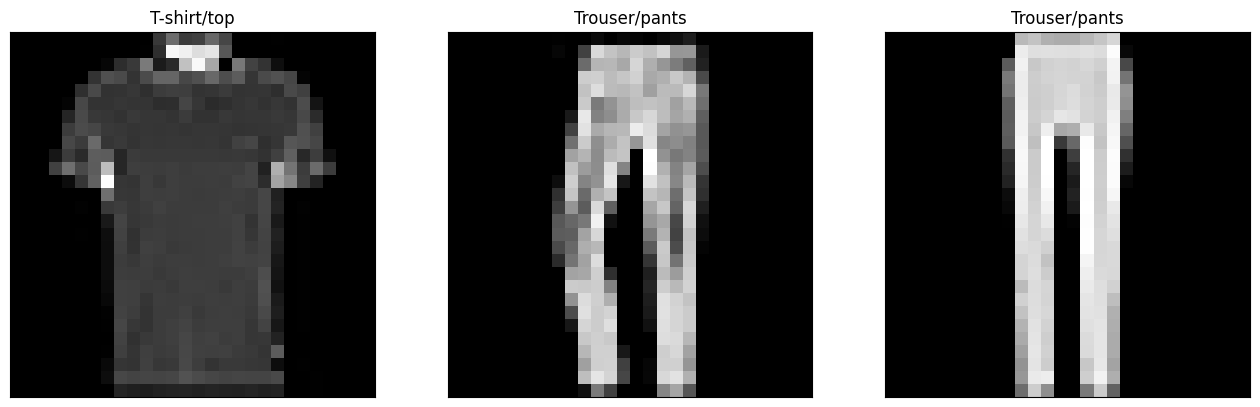

In [ ]:
xb = xb.cpu()
show_imgs(xb[:3], title=i2c[preds[:3]]);

# Logistic Regression and SGD from scratch

## Logistic Regression

In [ ]:
import pdb  # Python debugger

In [ ]:
class MyLogReg(nn.Module):  # our own 'layer' must inherit from nn.Module
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(tc.randn(28*28,10)/(28*28))  # all nn.Parameter() objects will be registered by PyTorch automatically
        self.b = nn.Parameter(tc.zeros((10,)))             # if we later do module.parameters() they will be there

    def forward(self, x):  # forward pass -> need this method in every nn.Module
        x = x.view(x.shape[0], -1)
        x = x @ self.w + self.b  # '@' is equivalent to torch.mm(x,self.w) or torch.dot(x,self.w)
        # pdb.set_trace()
#         x -= x.max()
#         x -= x.max(dim=1,keepdim=True)[0]
        x = tc.log(tc.exp(x)/(tc.exp(x).sum(dim=1)[:,None])) # LogSoftmax
        return x

In [ ]:
net = MyLogReg().cuda()
opt = optim.SGD(net.parameters(), 3e-3, momentum=0.9, weight_decay=1e-3)

In [ ]:
list(net.parameters())

[Parameter containing:
 tensor([[ 0.0005, -0.0006,  0.0006,  ...,  0.0001,  0.0015, -0.0032],
         [-0.0004,  0.0003,  0.0009,  ..., -0.0005, -0.0004, -0.0022],
         [-0.0014, -0.0011,  0.0023,  ...,  0.0013,  0.0016, -0.0001],
         ...,
         [ 0.0011, -0.0016, -0.0005,  ...,  0.0012,  0.0003,  0.0024],
         [-0.0002, -0.0002, -0.0010,  ..., -0.0013, -0.0003, -0.0013],
         [ 0.0004, -0.0007,  0.0003,  ..., -0.0012,  0.0002,  0.0013]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
        requires_grad=True)]

In [ ]:
dl = iter(tr_dl)

for i in trange(100):
    xb, yb = next(dl)
    xb, yb = xb.cuda(), yb.cuda()
    y_ = net(xb)
    l = loss(y_, yb)
    if i % 10 == 0:  # every 10 batches show accuracy for this single batch (will be noisy)
        acc = (y_.max(dim=1)[1] == yb).float().mean()
        print(f'loss: {l.data:0.4f}\t accuracy: {acc}')
    opt.zero_grad()
    l.backward()
    opt.step()

  0%|          | 0/100 [00:00<?, ?it/s]

loss: 2.3011	 accuracy: 0.125
loss: 1.9314	 accuracy: 0.375
loss: 1.8912	 accuracy: 0.375
loss: 1.6828	 accuracy: 0.25
loss: 1.1883	 accuracy: 0.625
loss: 1.1502	 accuracy: 0.875
loss: 1.3684	 accuracy: 0.375
loss: 0.9595	 accuracy: 0.75
loss: 1.1757	 accuracy: 0.75
loss: 0.9773	 accuracy: 0.75


## Stochastic Gradient Descent

In [ ]:
net = MyLogReg().cuda()
loss = nn.NLLLoss()
lr = 1e-2
epochs = 3

In [ ]:
for epoch in trange(epochs):
    L = []  # to store the losses
    for xb, yb in tqdm(iter(tr_dl), leave=False):
        xb, yb = xb.cuda(), yb.cuda()
        y_ = net(xb)
        l = loss(y_, yb)
        l.backward()

        # opt.step() for SGD w/o momentum and w/o weight decay
        net.w.data -= net.w.grad.data * lr  # equiv to: net.w.data = net.w.data - net.w.grad.data * lr
        net.b.data -= net.b.grad.data * lr

        # opt.zero_grad()
        net.w.grad.data.zero_() # equivalent to net.w.grad.data = net.w.grad.data.zero()
        net.b.grad.data.zero_()

        L.append(l.detach().cpu().numpy())

    # # disable gradient calculations for validation
    # for p in net.parameters(): p.requires_grad = False

    Lval, Aval = [], []
    with tc.no_grad():  # due to this validation batch size can be bigger
        for xb, yb in tqdm(iter(val_dl), leave=False):
            xb, yb = xb.cuda(), yb.cuda()
            y_ = net(xb)
            l = loss(y_, yb)
            Lval.append(l.detach().cpu().numpy())
            Aval.append((y_.max(dim=1)[1] == yb).float().mean().cpu().numpy())

    # # enable gradient calculations for next epoch
    # for p in net.parameters(): p.requires_grad = True

    print(f'training loss: {np.mean(L):0.4f}\tvalidation loss: {np.mean(Lval):0.4f}\tvalidation accuracy: {np.mean(Aval):0.2f}')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

training loss: 0.6309	validation loss: 0.5468	validation accuracy: 0.81


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

training loss: 0.4957	validation loss: 0.4680	validation accuracy: 0.84


  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

training loss: 0.4679	validation loss: 0.4490	validation accuracy: 0.85


# Homework

## For all

The training loop above is quite messy, the forward pass is coded twice for example (once for the trainig set and once for the validation set). Your task is to clean it up by moving the duplicate code into a separate function.

## For volunteers

Prepare a notebook comparing our Logistic Regression model using different optimisers available in `torch.optim`. As a minimum you should compare `SGD` (with and without momentum) and `Adam` and a few learning rates.